# Hypernym Prediction task with Generative models

Given an input term, retrieve (or discover) its suitable hypernyms/parents.

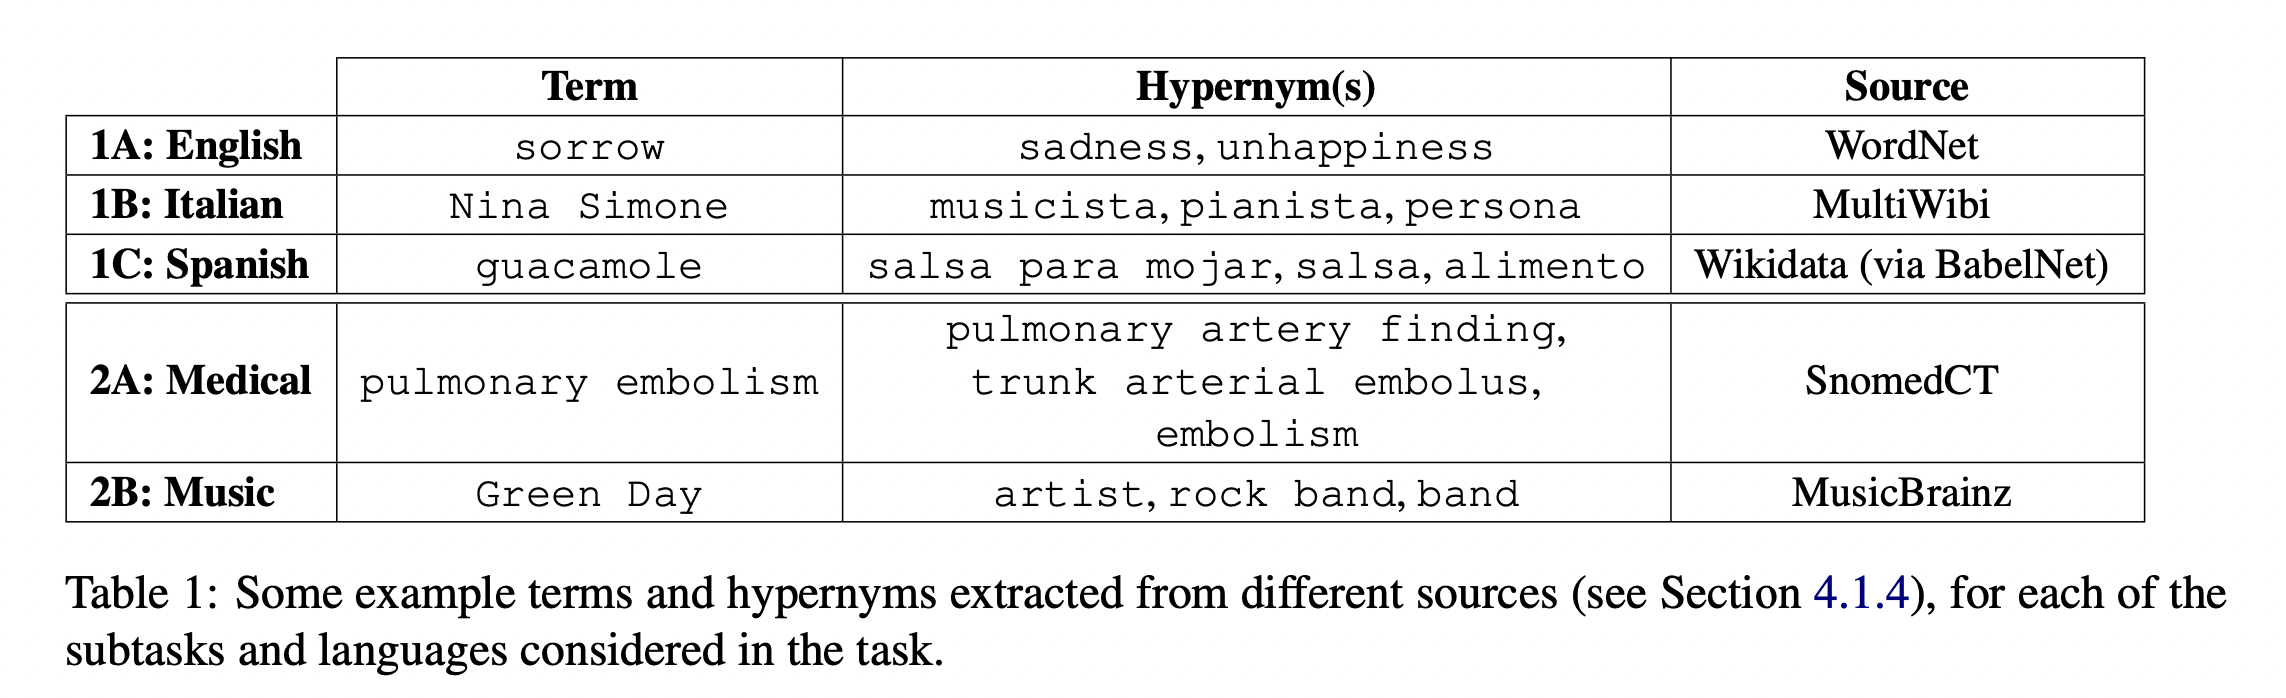

The task belongs to the lexico-sematintic domain, however, as we can see later, it is still difficult for the LLMs.

## Download the data

In [5]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1EQ7KmpLDgG9_bHbt1Mjz4acKjDQWpMza' -O SemEval2018-Task9.zip

!unzip SemEval2018-Task9.zip
!rm SemEval2018-Task9.zip

--2025-04-03 16:54:11--  https://docs.google.com/uc?export=download&id=1EQ7KmpLDgG9_bHbt1Mjz4acKjDQWpMza
Resolving docs.google.com (docs.google.com)... 142.251.31.138, 142.251.31.100, 142.251.31.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.31.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1EQ7KmpLDgG9_bHbt1Mjz4acKjDQWpMza&export=download [following]
--2025-04-03 16:54:11--  https://drive.usercontent.google.com/download?id=1EQ7KmpLDgG9_bHbt1Mjz4acKjDQWpMza&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.143.132, 2a00:1450:4013:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.143.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2509363 (2.4M) [application/octet-stream]
Saving to: ‘SemEval2018-Task9.zip’

SemEval2018-Task9.z 100%[===================>]   2.39M  --.-KB

In [6]:
path_x = 'training/data/1A.english.training.data.txt'
path_y = 'training/gold/1A.english.training.gold.txt'

path_x_test = 'test/data/1A.english.test.data.txt'
path_y_test = 'test/gold/1A.english.test.gold.txt'

In [7]:
import pandas as pd

In [8]:
def read_Y(path):
    with open(path) as input:
        Y = [line.rstrip('\n').split('\t') for line in input]
    return Y

In [9]:
df = pd.read_csv(path_x, sep='\t', header= None, names=['hyponym', 'property'])
df_test = pd.read_csv(path_x_test, sep='\t', header= None, names=['hyponym', 'property'])

df.insert(2, 'hypernyms', read_Y(path_y))
df_test.insert(2, 'hypernyms', read_Y(path_y_test))

df['hypernyms'] = [', '.join(map(str, l)) for l in df['hypernyms']]
df_test['hypernyms'] = [', '.join(map(str, l)) for l in df_test['hypernyms']]

In [8]:
df_test.head()

,hyponym,property,hypernyms
0,maliciousness,Concept,"malevolence, distaste, hatred, hate, malignity"
1,buckler,Concept,body armor
2,spelunker,Concept,"exploration, adventurer, explorer"
3,quo warranto,Concept,"proceedings, legal proceedings, proceeding, du..."
4,Jeff Francis,Entity,"thrower, baseball player, jock, person"


## Text processing

In [10]:
def generate_input_prompt(dataframe):
    _input = []
    for hyponym in dataframe.hyponym:
        input_text = f"hyponym: {hyponym}, predict hypernyms:"
        _input.append(input_text)
    return _input

In [10]:
df.insert(3, 'hyponyms_input', generate_input_prompt(df))
df_test.insert(3, 'hyponyms_input', generate_input_prompt(df_test))

In [11]:
df.head()

,hyponym,property,hypernyms,hyponyms_input
0,blackfly,Concept,"homopterous insect, insect","hyponym: blackfly, predict hypernyms:"
1,Turonian,Entity,"technical specification, geologic timescale, p...","hyponym: Turonian, predict hypernyms:"
2,abhorrence,Concept,"distaste, hatred, hate, disgust","hyponym: abhorrence, predict hypernyms:"
3,tropical storm,Concept,"atmosphere, windstorm, violent storm, air curr...","hyponym: tropical storm, predict hypernyms:"
4,militarization,Concept,social control,"hyponym: militarization, predict hypernyms:"


## Dataset construction

In [11]:
!pip install transformers

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

In [13]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [14]:
class PairsDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        assert idx <= len(self.x['input_ids']), (idx, len(self.x['input_ids']))
        item = {key: val[idx] for key, val in self.x.items()}
        item['labels'] = self.y['input_ids'][idx]
        return item

    @property
    def n(self):
        return len(self.x['input_ids'])

    def __len__(self):
        return self.n

In [15]:
from typing import List, Dict, Union

class DataCollatorWithPadding:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        batch = self.tokenizer.pad(
            {'input_ids': features['input_ids'], 'attention_mask': features['attention_mask']},
            padding=True,
        )

        print(batch)

        ybatch = self.tokenizer.pad(
            {'input_ids': batch['labels'], 'attention_mask': batch['attention_mask']},
            padding=True,
        )
        batch['labels'] = ybatch['input_ids']
        #batch['decoder_attention_mask'] = ybatch['attention_mask']

        return {k: torch.tensor(v) for k, v in batch.items()}

## Model loading

In [16]:
!pip install sentencepiece

In [17]:
pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [18]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base").cuda()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## Test zero-shot setup

In [20]:
import re
from tqdm import tqdm
import collections

In [19]:
p = re.compile(r"[,\s]")
with open("./res_zeroshot_t5", "w", encoding='utf-8') as w:
    for i_2, j_2 in tqdm(zip(df_test['hyponyms_input'].tolist(), df_test['hypernyms'].tolist()), total=1500):
        input_ids = tokenizer.encode(i_2, return_tensors="pt")
        outputs = model.generate(input_ids.to('cuda'), no_repeat_ngram_size=2, max_new_tokens=50,
                                      num_return_sequences=5, early_stopping=True, do_sample=True, num_beams=5)
        decoded = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        decoded = [j for i in decoded for j in i.split(", ")]
        decoded = [i for i in decoded if i and i!='.' and i!=',']
        decoded = [i[0].strip() for i in list(collections.Counter(decoded).most_common())]
        w.write('\t'.join(decoded)+'\n')

100%|██████████| 1500/1500 [08:20<00:00,  3.00it/s]


In [20]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [21]:
!python task9-scorer.py test/gold/1A.english.test.gold.txt res_zeroshot_t5

MRR: 0.001
MAP: 0.0002719656886323553
P@1: 0.0006666666666666666
P@3: 0.0004444444444444444
P@5: 0.0002666666666666667
P@15: 0.00015584415584415584


## Test few-shot setup

hyponym: narcolepsy, predict hypernyms: illness

hyponym: Scott City, predict hypernyms: town, city

hyponym: noun, predict hypernyms: substantive


hyponym: spelunker, predict hypernyms:

In [21]:
def add_examples(text):
    examples = [" ".join(i) for i in df.sample(n=3)[['hyponyms_input', 'hypernyms']].values.tolist()]
    examples = "\n".join(examples)
    return examples + "\n" + text

In [22]:
df_test['hyponyms_extended_input'] = df_test['hyponyms_input'].apply(add_examples)

In [23]:
df_test.head()

,hyponym,property,hypernyms,hyponyms_input,hyponyms_extended_input
0,maliciousness,Concept,"malevolence, distaste, hatred, hate, malignity","hyponym: maliciousness, predict hypernyms:","hyponym: perfidiousness, predict hypernyms: pr..."
1,buckler,Concept,body armor,"hyponym: buckler, predict hypernyms:","hyponym: Otto von Habsburg, predict hypernyms:..."
2,spelunker,Concept,"exploration, adventurer, explorer","hyponym: spelunker, predict hypernyms:","hyponym: Pauli, predict hypernyms: physicist, ..."
3,quo warranto,Concept,"proceedings, legal proceedings, proceeding, du...","hyponym: quo warranto, predict hypernyms:","hyponym: release notes, predict hypernyms: com..."
4,Jeff Francis,Entity,"thrower, baseball player, jock, person","hyponym: Jeff Francis, predict hypernyms:","hyponym: webmail, predict hypernyms: website, ..."


In [25]:
p = re.compile(r"[,\s]")
with open("./res_fewshot_flan-t5", "w", encoding='utf-8') as w:
    for i_2, j_2 in tqdm(zip(df_test['hyponyms_extended_input'].tolist(), df_test['hypernyms'].tolist()), total=1500):
        input_ids = tokenizer.encode(i_2, return_tensors="pt")
        outputs = model.generate(input_ids.to('cuda'), no_repeat_ngram_size=2, max_new_tokens=2048,
                                      num_return_sequences=5, early_stopping=True, do_sample=True, num_beams=5)
        decoded = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        decoded = [j for i in decoded for j in i.split(", ")]
        decoded = [i for i in decoded if i and i!='.' and i!=',']
        decoded = [i[0].strip() for i in list(collections.Counter(decoded).most_common())]
        w.write('\t'.join(decoded)+'\n')

100%|██████████| 1500/1500 [35:01<00:00,  1.40s/it]


In [26]:
!python task9-scorer.py test/gold/1A.english.test.gold.txt res_fewshot_flan-t5

MRR: 0.009527777777777777
MAP: 0.004848849175515841
P@1: 0.004666666666666667
P@3: 0.004666666666666665
P@5: 0.005388888888888889
P@15: 0.004751322751322751


In [27]:
!python task9-scorer.py test/gold/1A.english.test.gold.txt res_fewshot_flan-t5

MRR: 0.009527777777777777
MAP: 0.004848849175515841
P@1: 0.004666666666666667
P@3: 0.004666666666666665
P@5: 0.005388888888888889
P@15: 0.004751322751322751


## Finetuning

In [24]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
import gc

In [25]:
train_dataset = PairsDataset(tokenizer(df['hyponyms_input'].tolist(), padding="max_length",  max_length=50, truncation=True),
                              tokenizer(df['hypernyms'].tolist(),  padding="max_length",  max_length=50, truncation=True))
test_dataset = PairsDataset(tokenizer(df_test['hyponyms_input'].tolist(),  padding="max_length",  max_length=50, truncation=True),
                            tokenizer(df_test['hypernyms'].tolist(),  padding="max_length",  max_length=50, truncation=True))

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [38]:
import wandb
wandb.init(mode='disabled')

args = TrainingArguments(output_dir="bart-base-finetuned", num_train_epochs=10, per_device_train_batch_size=32, save_steps=10000)

trainer = Trainer(
    model = model,
    args = args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    tokenizer = tokenizer
)

<ipython-input-38-c41d1542fd1d>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [39]:
def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [40]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss


TrainOutput(global_step=470, training_loss=1.446530476022274, metrics={'train_runtime': 365.3894, 'train_samples_per_second': 41.052, 'train_steps_per_second': 1.286, 'total_flos': 892028160000000.0, 'train_loss': 1.446530476022274, 'epoch': 10.0})

In [41]:
current_model_name = "t5-base-finetuned"

trainer.save_model(current_model_name)

In [42]:
model_saved = current_model_name
model = T5ForConditionalGeneration.from_pretrained(model_saved).to('cuda')
tokenizer = T5Tokenizer.from_pretrained(model_saved)

In [43]:
from tqdm import tqdm

In [44]:
import collections
import re

In [45]:
p = re.compile(r"[,\s]")
with open("./res_"+current_model_name, "w", encoding='utf-8') as w:
    for i_2, j_2 in tqdm(zip(df_test['hyponyms_input'].tolist(), df_test['hypernyms'].tolist()), total=1500):
        input_ids = tokenizer.encode(i_2, return_tensors="pt")
        outputs = model.generate(input_ids.to('cuda'), no_repeat_ngram_size=2, max_new_tokens=2048,
                                      num_return_sequences=5, early_stopping=True, do_sample=True, num_beams=5)
        decoded = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        decoded = [j for i in decoded for j in i.split(", ")]
        decoded = [i for i in decoded if i and i!='.' and i!=',']
        decoded = [i[0].strip() for i in list(collections.Counter(decoded).most_common())]
        w.write('\t'.join(decoded)+'\n')

100%|██████████| 1500/1500 [06:05<00:00,  4.10it/s]


In [46]:
!python task9-scorer.py test/gold/1A.english.test.gold.txt res_t5-base-finetuned

Traceback (most recent call last):
  File "/content/task9-scorer.py", line 92, in <module>
    fpredictions = open(predictions, 'r')
                   ^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'res_flan-t5-base-finetuned'
